     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done

--- Interpretation ---
Total listings analyzed: 18305
English listings: 7866 | Spanish listings: 10439
Average price for English listings: $141.47
Average price for Spanish listings: $120.27
Median price for English listings: $70.00
Median price for Spanish listings: $50.00
Price difference (mean): $21.20 (17.63%)
⚠ There is a significant price inflation for English-language listings, suggesting price targeting towards tourists.


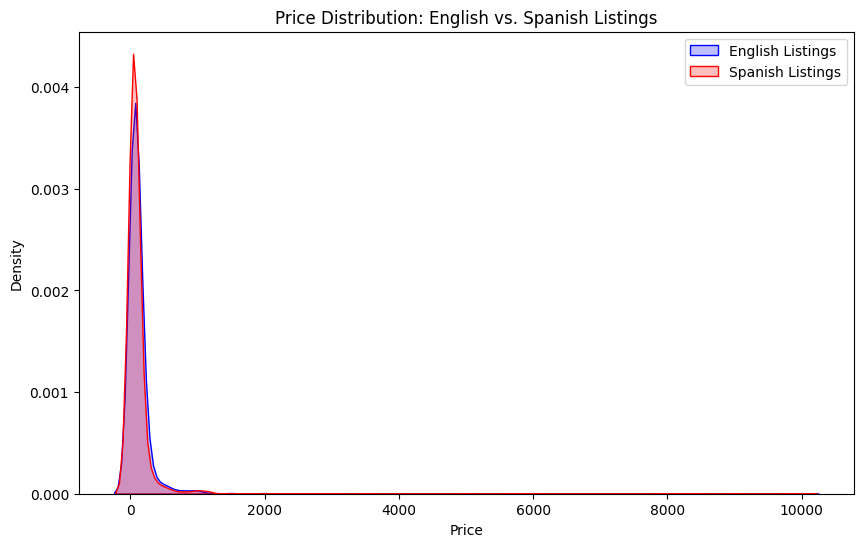

<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22826 (\N{CJK UNIFIED IDEOGRAPH-592A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38451 (\N{CJK UNIFIED IDEOGRAPH-9633}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38376 (\N{CJK UNIFIED IDEOGRAPH-95E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24191 (\N{CJK UNIFIED IDEOGRAPH-5E7F}) missing from font(s) DejaVu Sans.
  fig.canvas

In [ ]:
# Install langdetect (if not already installed)
!pip install langdetect --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory
import numpy as np

# Ensure consistent language detection
DetectorFactory.seed = 0

# Load the dataset
file_path = "/content/listings_detailed.csv"
df = pd.read_csv(file_path)

# Identify relevant columns
text_col = [col for col in df.columns if 'description' in col.lower()]
price_col = [col for col in df.columns if 'price' in col.lower()]
district_col = [col for col in df.columns if 'district' in col.lower() or 'neigh' in col.lower()]

if not text_col or not price_col:
    raise ValueError("Could not find necessary columns for description or price in the dataset.")

text_col = text_col[0]
price_col = price_col[0]
district_col = district_col[0] if district_col else None

# Convert price to numeric if it's not already
df[price_col] = df[price_col].replace('[\$,]', '', regex=True).astype(float)

# Function to detect language safely
def detect_language(text):
    try:
        return detect(str(text))
    except:
        return "unknown"

# Apply language detection
df['language'] = df[text_col].apply(detect_language)

# Filter only English and Spanish listings
df_filtered = df[df['language'].isin(['en', 'es'])]

# Price comparison
english_prices = df_filtered[df_filtered['language'] == 'en'][price_col]
spanish_prices = df_filtered[df_filtered['language'] == 'es'][price_col]

# Statistical summary
mean_price_en = english_prices.mean()
mean_price_es = spanish_prices.mean()
median_price_en = english_prices.median()
median_price_es = spanish_prices.median()
price_difference = mean_price_en - mean_price_es
percentage_difference = ((mean_price_en - mean_price_es) / mean_price_es) * 100

# Interpretation
print("\n--- Interpretation ---")
print(f"Total listings analyzed: {len(df_filtered)}")
print(f"English listings: {len(english_prices)} | Spanish listings: {len(spanish_prices)}")
print(f"Average price for English listings: ${mean_price_en:.2f}")
print(f"Average price for Spanish listings: ${mean_price_es:.2f}")
print(f"Median price for English listings: ${median_price_en:.2f}")
print(f"Median price for Spanish listings: ${median_price_es:.2f}")
print(f"Price difference (mean): ${price_difference:.2f} ({percentage_difference:.2f}%)")

if percentage_difference > 15:
    print("⚠ There is a significant price inflation for English-language listings, suggesting price targeting towards tourists.")
elif percentage_difference > 5:
    print("⚠ There is a moderate price difference between English and Spanish listings.")
else:
    print("✅ Prices appear relatively balanced between English and Spanish listings.")

# Visualization: Price Distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(english_prices, label="English Listings", fill=True, color="blue")
sns.kdeplot(spanish_prices, label="Spanish Listings", fill=True, color="red")
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price Distribution: English vs. Spanish Listings")
plt.legend()
plt.show()

# If district data is available, analyze district-level price differences
if district_col:
    district_analysis = df_filtered.groupby([district_col, 'language'])[price_col].mean().unstack()

    # Plot district-level differences
    plt.figure(figsize=(12, 6))
    district_analysis.plot(kind='bar', figsize=(12, 6), colormap="coolwarm", width=0.8)
    plt.ylabel("Average Price")
    plt.xlabel("District")
    plt.title("Average Price by District: English vs. Spanish Listings")
    plt.xticks(rotation=45)
    plt.legend(["Spanish Listings", "English Listings"])
    plt.show()

    # Identify districts where the difference is highest
    district_analysis['Difference'] = district_analysis['en'] - district_analysis['es']
    district_analysis = district_analysis.sort_values('Difference', ascending=False)

    print("\nDistricts with the Highest Price Inflation for English Listings:")
    print(district_analysis[['Difference']].head(10))